Namespace(backend='theano', batch_size=32, bn_mode=2, clamp_lower=-0.01, clamp_upper=0.01, deterministic=True, disc_iterations=15, discriminator='discriminator', dset='mnistM', generator='upsampling', img_dim=64, inject_noise=False, lr_D=5e-05, lr_G=5e-05, model='wgan', n_batch_per_epoch=1000, name='wgan', nb_epoch=10000, no_supertrain=False, noise_dim=100, noise_scale=0.5, opt_D='RMSprop', opt_G='RMSprop', resume=True, use_mbd=False)


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)



Experiment parameters:
noise_dim 100
image_dim_ordering th
use_mbd False
discriminator discriminator
clamp_lower -0.01
generator upsampling
nb_epoch 10000
deterministic True
n_batch_per_epoch 1000
disc_iterations 15
no_supertrain False
clamp_upper 0.01
opt_G RMSprop
opt_D RMSprop
resume True
batch_size 32
dset mnistM
name wgan
noise_scale 0.5
bn_mode 2
lr_G 5e-05
img_dim 64
lr_D 5e-05
inject_noise False
model wgan


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
generator_image_input (InputLaye (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 28, 28)    640         generator_image_input[0][0]      
__________________________________________________________________________

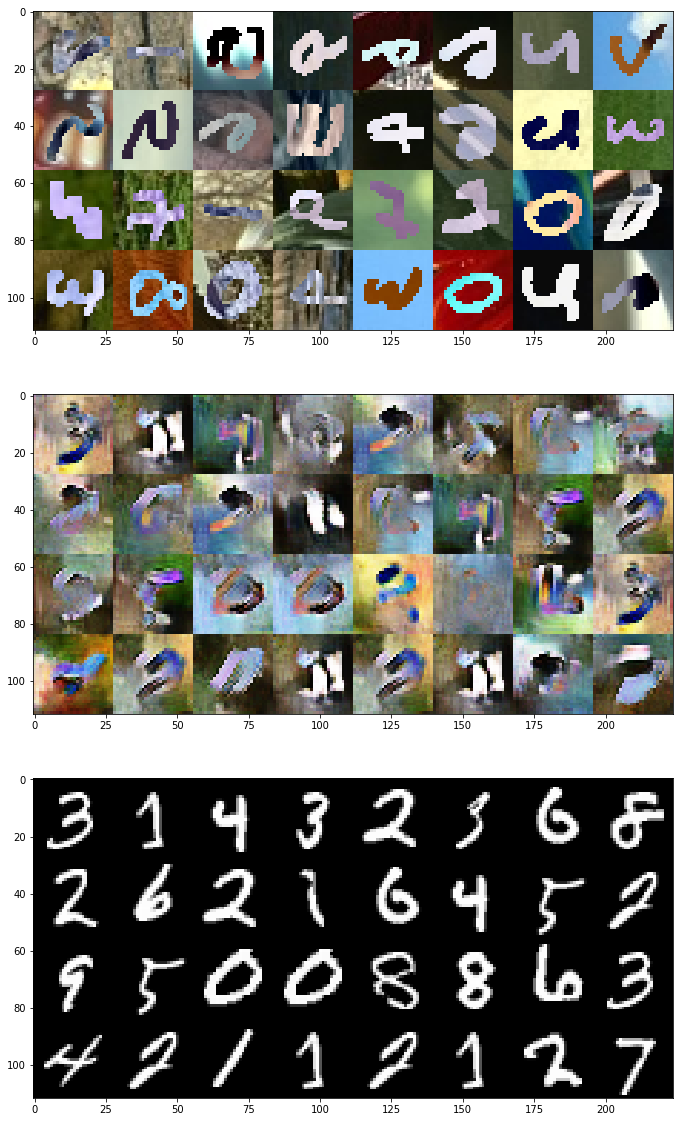


Epoch 1/10000, Time: 251.524796963
31968/32000 [============================>.] - ETA: 0s - Loss_D: 5.3990e-06 - Loss_D_real: 1.2096e-06 - Loss_D_gen: -4.1895e-06 - Loss_G: -1.1211e-05  

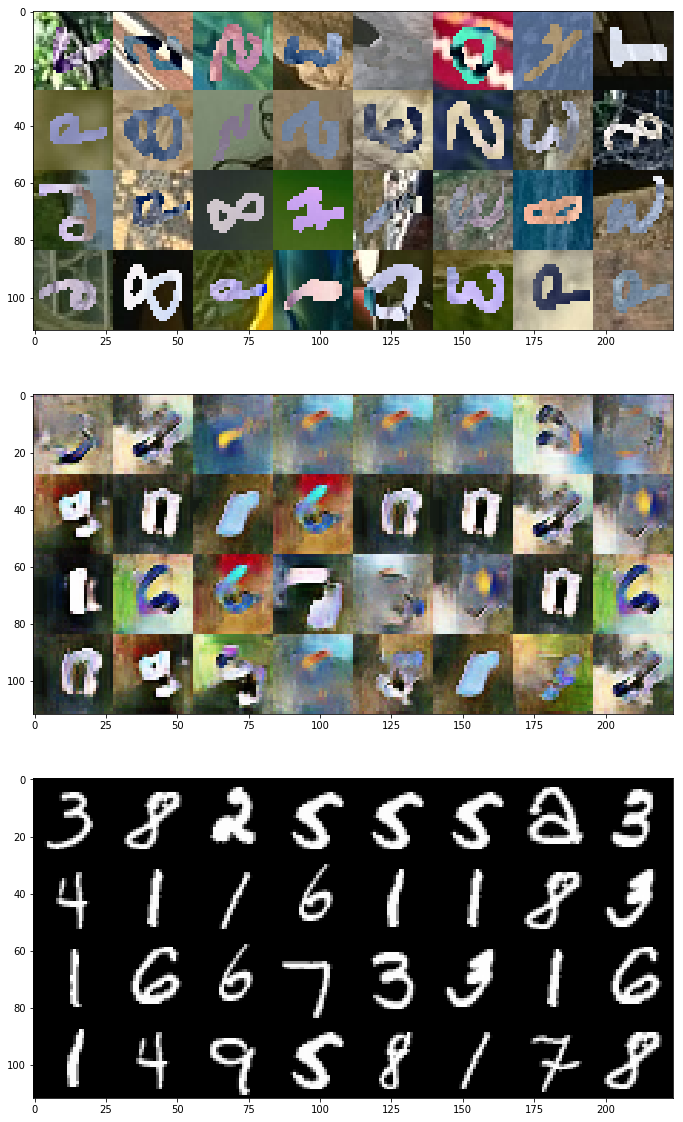


Epoch 2/10000, Time: 216.070166111
31968/32000 [============================>.] - ETA: 0s - Loss_D: 5.1223e-06 - Loss_D_real: 1.0197e-06 - Loss_D_gen: -4.1026e-06 - Loss_G: -1.0920e-05  

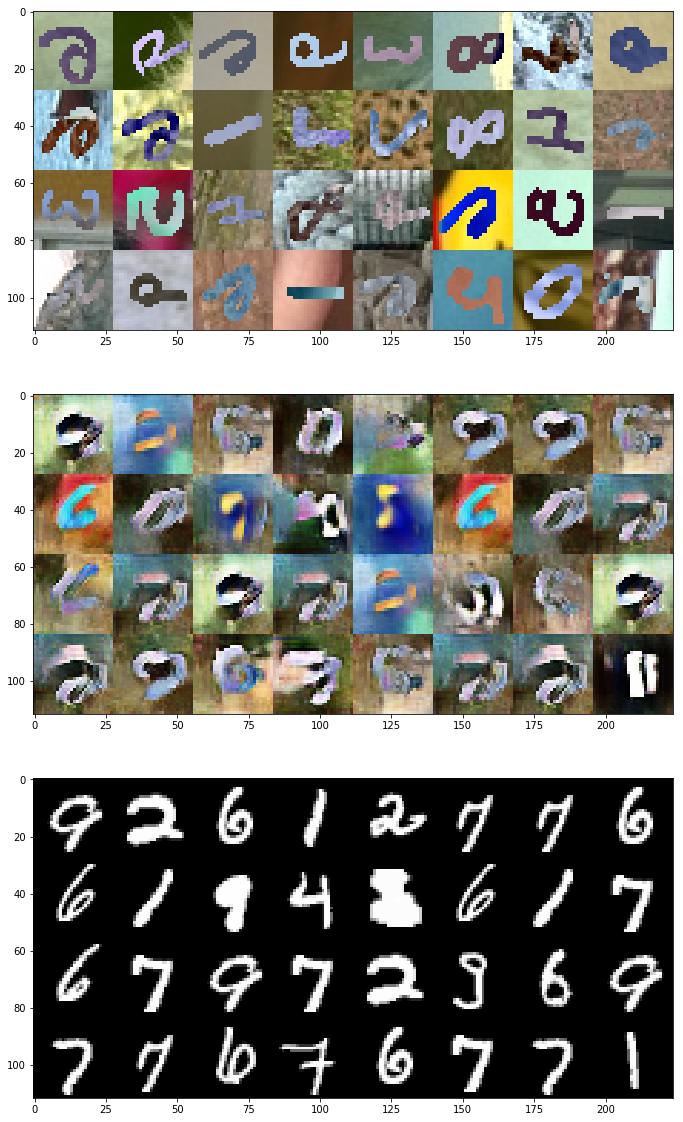


Epoch 3/10000, Time: 215.426645994
28576/32000 [=========================>....] - ETA: 23s - Loss_D: 4.9112e-06 - Loss_D_real: 7.7609e-07 - Loss_D_gen: -4.1351e-06 - Loss_G: -1.0712e-05 

KeyboardInterrupt: 

In [1]:
#%matplotlib inline
import os 
import argparse
import random

random.seed()
os.environ["THEANO_FLAGS"]  = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
parser = argparse.ArgumentParser(description='Train model')                                                 
parser.add_argument('--backend', type=str, default="theano", help="theano or tensorflow")                      
parser.add_argument('--generator', type=str, default="upsampling", help="upsampling or deconv or subpixel")    
parser.add_argument('--discriminator', type=str, default="discriminator", help="discriminator discriminator_resnet")
parser.add_argument('--dset', type=str, default="mnist", help="mnistM or washington_vandal50k or washington_vandal12classes")             
parser.add_argument('--img_dim', default=64, type=int, help="Image width == height")                           
parser.add_argument('--nb_epoch', default=1200, type=int, help="Number of epochs")                              
parser.add_argument('--batch_size', default=32, type=int, help='Batch size')                                   
parser.add_argument('--n_batch_per_epoch', default=1000, type=int, help="Number of batch per epochs")           
parser.add_argument('--bn_mode', default=2, type=int, help="Batch norm mode")                                  
parser.add_argument('--noise_dim', default=100, type=int, help="noise sampler dimension")                      
parser.add_argument('--noise_scale', default=0.5, type=float, help="noise sampler variance")                   
parser.add_argument('--disc_iterations', default=5, type=int, help="Number of discriminator iterations")
parser.add_argument('--clamp_lower', default=-0.01, type=float, help="Clamp weights below this value")         
parser.add_argument('--clamp_upper', default=0.01, type=float, help="Clamp weights above this value")          
parser.add_argument('--opt_D', type=str, default="RMSprop", help="Optimizer for the discriminator")            
parser.add_argument('--opt_G', type=str, default="RMSprop", help="Optimizer for the generator")                
parser.add_argument('--lr_D', type=float, default=5E-5, help="learning rate for the discriminator")            
parser.add_argument('--lr_G', type=float, default=5E-5, help="learning rate for the generator")                
parser.add_argument('--use_mbd', action="store_true", help="use mini batch disc")
parser.add_argument('--deterministic', action="store_true", help="remove the noise input")
parser.add_argument('--inject_noise', action="store_true", help="inject noise into each layer")
parser.add_argument('--model', type=str, default="wgan", help="wgan or lsgan") 
parser.add_argument('--no_supertrain', action="store_true", help="no discriminator supertraining") 
parser.add_argument('--resume', action="store_true", help="load GAN weights from previous train")
parser.add_argument('--name', type=str, default="wgan", help="name of the run, used for saving and loading weights") 

###simulating the main.py calling with corresponding parameters:
args = parser.parse_args(' --resume --dset mnistM --nb_epoch 10000 --deterministic --img_dim 64 --batch_size 32 --disc_iterations 15 --lr_D 5E-5 --lr_G 5E-5'.split())
######
print args
assert args.dset in ["mnistM","washington_vandal50k","washington_vandal12classes","washington_vandal12classesNoBackground"]                                                      
assert args.opt_G in ["RMSprop", "SGD", "Adam", "AdamWithWeightnorm"], "Unsupported optimizer"                 
assert args.opt_D in ["RMSprop", "SGD", "Adam", "AdamWithWeightnorm"], "Unsupported optimizer" 

# Set the backend by modifying the env variable                                                                
if args.backend == "theano":                                                                                   
    os.environ["KERAS_BACKEND"] = "theano"                                                                     
elif args.backend == "tensorflow":                                                                             
    os.environ["KERAS_BACKEND"] = "tensorflow"  
import keras.backend as K
# manually set dim ordering otherwise it is not changed                                                        
if args.backend == "theano":                                                                                   
    image_dim_ordering = "th"                                                                                  
    K.set_image_dim_ordering(image_dim_ordering)                                                               
elif args.backend == "tensorflow":                                                                             
    image_dim_ordering = "tf"                                                                                  
    K.set_image_dim_ordering(image_dim_ordering)
import train_WGAN
# Set default params
d_params = {"generator": args.generator,
            "discriminator": args.discriminator,
            "dset": args.dset,
            "img_dim": args.img_dim,
            "nb_epoch": args.nb_epoch,
            "batch_size": args.batch_size,
            "n_batch_per_epoch": args.n_batch_per_epoch,
            "bn_mode": args.bn_mode,
            "noise_dim": args.noise_dim,
            "noise_scale": args.noise_scale,
            "disc_iterations": args.disc_iterations,
            "clamp_lower": args.clamp_lower,
            "clamp_upper": args.clamp_upper,
            "lr_D": args.lr_D,
            "lr_G": args.lr_G,
            "opt_D": args.opt_D,
            "opt_G": args.opt_G,
            "use_mbd": args.use_mbd,
            "deterministic": args.deterministic,
            "image_dim_ordering": image_dim_ordering,
            "model": args.model,
            "no_supertrain": args.no_supertrain,
            "resume": args.resume,
            "name": args.name,
            "inject_noise": args.inject_noise
            }
# Launch training
#if d_params["dset"] == "toy":
#    train_WGAN.train_toy(**d_params)
#else:
#    train_WGAN.train(**d_params)
# Launch training
if d_params["dset"] == "toy":
    train_WGAN.train_toy(**d_params)
else:
    train_WGAN.train(**d_params)